# Imports

In [1]:
import numpy
import matplotlib.pyplot as plt


# Introduction

To calculate the rate at which we form (and eventually merge) 
binaries we need to know how much 
mass is evolved in all stars with primaries from an initial mass function (a broken powerlaw)
and secondaries (with some binary fraction and mass ratio distribution)
to create each individual binary.

This notebook contains the following

1 How to create the code to do the inversion sampling of the broken powerlaw

2 The loop for the sample universe (i.e draw M1s and corresponding M2s)

3 Determine the fraction evolved of all star formation by COMPAS



# 1 Inversion sampling

A powerlaw is an equation of the form
$$ P = C x^{\alpha} $$

integral F of power law P from a to b:

$$ F =  \left[ \frac{1}{(\alpha + 1)} C x ^{\alpha + 1} \right]_{a}^{b} $$

making this into a cumulative density function (CDF) means total of integral is normalized.
so the CDF(a) where x goes from xmin to xmax:

$$ F =  \frac{\left[ \frac{1}{(\alpha + 1)} C x ^{\alpha + 1} \right]_{xmin}^{a} }
         { \left[ \frac{1}{(\alpha + 1)} C x ^{\alpha + 1} \right]_{xmin}^{xmax} } $$

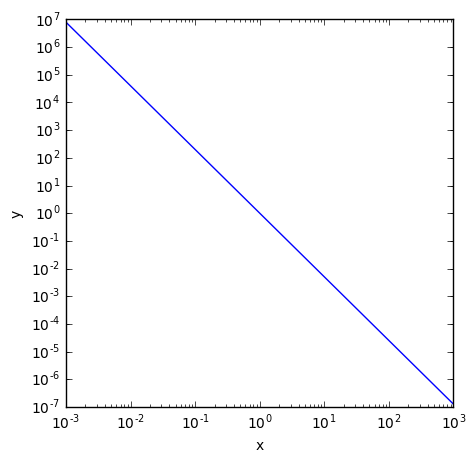

In [2]:
def powerLaw(C, x, index):
    return (1./C)*x**(index)


alpha = -2.3
x = numpy.logspace(-3,3, 100)
fig, axes = plt.subplots(1,1, figsize=(5,5))
axes.plot(x, powerLaw(1, x, alpha))
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel('x')
axes.set_ylabel('y')
plt.show()

In [3]:
def cumulativePowerLaw(C, x, index, xmin, xmax):
    a =  (1./(index + 1)) * C * x**(index+1)
    b =  (1./(index + 1)) * C * xmin**(index+1)
    c =  (1./(index + 1)) * C * xmax**(index+1)

    CDF = (a - b)/float(c-b)
    return CDF

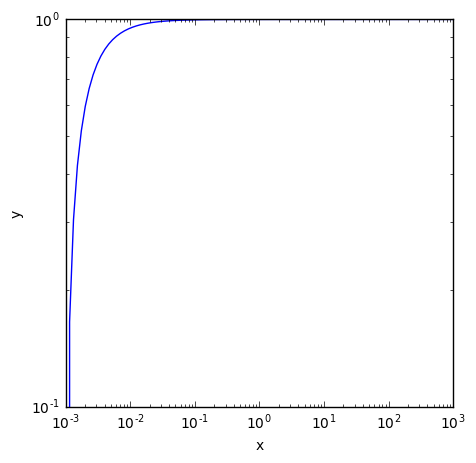

In [4]:
alpha = -2.3
x = numpy.logspace(-3,3, 100)
fig, axes = plt.subplots(1,1, figsize=(5,5))
axes.plot(x, cumulativePowerLaw(1, x, alpha, 0.001, 1000.))
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlabel('x')
axes.set_ylabel('y')
plt.show()

The benefit of a CDF is that the inverse (solving for x) immediatly maps a number between 0-1 to an x value
so you can quickly draw a sample without accept-reject method.


$$ F =  \frac{\left[ \frac{1}{(\alpha + 1)} C x ^{\alpha + 1} \right]_{xmin}^{x} }
         { \left[ \frac{1}{(\alpha + 1)} C x ^{\alpha + 1} \right]_{xmin}^{xmax} } $$
         

Not sure if people are familiar with above notation so more explicitly

$$ F = \frac{ \left[ \left( \frac{1}{(\alpha + 1)} C x ^{\alpha + 1} \right) - \left(\frac{1}{(\alpha + 1)} C xmin ^{\alpha + 1} \right)  \right]}
       { \left[ \left( \frac{1}{(\alpha + 1)} C xmax ^{\alpha + 1} \right) - \left( \frac{1}{(\alpha + 1)} C xmin ^{\alpha + 1} \right)  \right]} $$
   
$$ F = \frac{ \left[ \left(\frac{1}{(\alpha + 1)} C x ^{\alpha + 1} \right) - b \right]}
       { \left[ c - b  \right]} $$
       
Solving for x gives 
$$\frac{((F * [c - b]) + b)*(\alpha + 1)}{C} =  x ^{\alpha + 1} $$



$$\left(\frac{((F * [c - b]) + b)*(\alpha + 1)}{C}\right)^{\frac{1}{\alpha + 1}} =  x $$


In [5]:
def inverseCDF(C, CDF, index, xmin, xmax):
    a =  (1./(index + 1)) * C * CDF**(index+1)
    b =  (1./(index + 1)) * C * xmin**(index+1)
    c =  (1./(index + 1)) * C * xmax**(index+1)
    top    = ((CDF * (c-b))+b)*(index + 1)
    bottom = C
    return (top/bottom)**(1./(index+1))

0.00100071678945 999.999950389


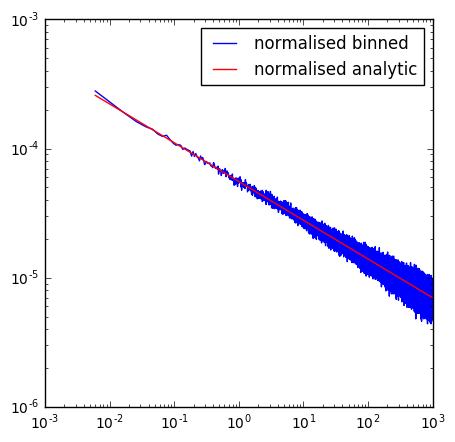

In [6]:
alpha = -0.3
draws   =  numpy.random.uniform(0,1,10*10**6)
xValues =  inverseCDF(1, draws, alpha, 0.001, 1000.)
print min(xValues), max(xValues)
bins = numpy.linspace(0.001, 1000, 100000)
hist, bins = numpy.histogram(xValues, bins=bins)
hist = hist/(float(numpy.sum(hist)))

center = (bins[:-1] + bins[1:]) / 2
fig, axes = plt.subplots(1,1, figsize=(5,5))

x = center
y = powerLaw(1, x, alpha)
y = y /(float(numpy.sum(y)))

axes.plot(center, hist, label=('normalised binned'))
axes.plot(x,y, c='r',  label=('normalised analytic'))
axes.set_xscale('log')
axes.set_yscale('log')
axes.legend()
plt.show()
#a histogram should recover the slope ofthe underlying distribution


# Three part broken powerlaw

Again a power-law as before, but now the index depends depends on x
$$ P = C x^{\alpha} $$

It has an index depending on the value of x


$\rm x_1 \leq x \leq x_2$ ,     $\rm \alpha = \alpha_1$

$\rm x_2 \leq x \leq x_3 $ ,   $\rm \alpha = \alpha_2$

$\rm x_3 \leq x \leq x_4 $ ,    $\rm \alpha = \alpha_3$

we know that we want to connect the power-laws so at x2:

$$ C_1 x_2^{\alpha_1} = C_2 x_2^{\alpha_2} $$

hence if we know C1

$$ C_2 = C_1 \frac{x_2^{\alpha_1}}{x_2^{\alpha_2}} = C_1 x_2^{\alpha_1 - \alpha_2} $$

and then at $x_3$:

$$ C_2 x_3^{\alpha_2} = C_3 x_3^{\alpha_3} => C_3 =  C_2 x_3^{\alpha_2 - \alpha_3} = C_1 x_2^{\alpha_1 - \alpha_2} x_3^{\alpha_2 - \alpha_3}$$


In [7]:
def threePartBrokenPowerLaw(x, x1, x2, x3, x4, a1, a2, a3, C1):
    #Not that everything outside the range x1<x4 is set to zero
    yvalues = numpy.zeros(len(x))
    
    #calculate values of the x values that are x1<=x<x2
    mask1 = (x>=x1) & (x<x2)
    yvalues[mask1] = C1 * (x[mask1]**a1)
    
    #calculate values of the x values that are x2<=x<x3
    mask2 = (x>=x2) & (x<x3)
    C2    = C1 * (x2**(a1-a2))
    yvalues[mask2] = C2 * (x[mask2]**a2)
    
    #calculate values of the x values that are x3<=x<=x4
    mask3 = (x>=x3) & (x<=x4)
    C3    = C1 * (x2**(a1-a2)) * (x3**(a2-a3))
    yvalues[mask3] = C3 * (x[mask3]**a3)
    
    return yvalues
    

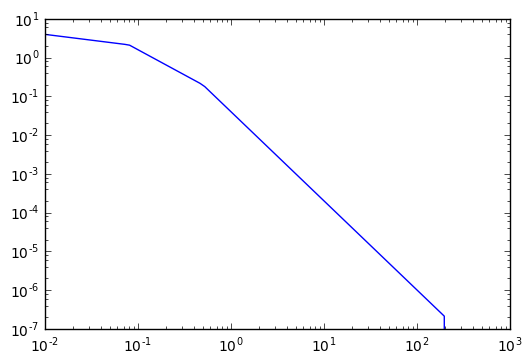

In [8]:
xmin = 0.01
xmax = 1000
xvalues = numpy.logspace(numpy.log10(xmin), numpy.log10(xmax), 100)
x1 = 0.01
x2 = 0.08
x3 = 0.5
x4 = 200
a1 = -0.3
a2 = -1.3
a3 = -2.3
C1 = 1
yvalues =threePartBrokenPowerLaw(xvalues, x1, x2, x3, x4, a1, a2, a3, C1)

fig, axes = plt.subplots(1,1)
axes.plot(xvalues, yvalues)
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlim(xmin, xmax)
plt.show()

Again we have to turn this into a cumulative function and solve it for x
to have the efficient sampling of the powerlaw when we draw numebrs between 0-1
and dont want to reject draws

The overall normalization (i.e. entire integral is):

$$ { \left[\frac{1}{(\alpha_1 + 1)} C_1 x ^{\alpha_1 + 1} \right]_{x_1}^{x_2} } + { \left[ \frac{1}{(\alpha_2 + 1)} C_2 x ^{\alpha_2 + 1} \right]_{x_2}^{x_3} } + { \left[ \frac{1}{(\alpha_3 + 1)} C_3 x ^{\alpha_3 + 1} \right]_{x_3}^{x_4} } $$

We then need to integrate from x1 to a and divide by the expression above to know the CDF at x=a:

If x < x2:
    
$$ CDF(a) = \frac{ \left[ \frac{1}{(\alpha_1 + 1)} C_1 x ^{\alpha_1 + 1} \right]_{x_1}^{a}}
            {{ \left[\frac{1}{(\alpha_1 + 1)} C_1 x ^{\alpha_1 + 1} \right]_{x_1}^{x_2} } + { \left[ \frac{1}{(\alpha_2 + 1)} C_2 x ^{\alpha_2 + 1} \right]_{x_2}^{x_3} } + { \left[ \frac{1}{(\alpha_3 + 1)} C_3 x ^{\alpha_3 + 1} \right]_{x_3}^{x_4} } }$$
             
If x2 < x < x3:

$$ CDF(a) = \frac{ \left[ \frac{1}{(\alpha_1 + 1)} C_1 x ^{\alpha_1 + 1} \right]_{x_1}^{x_2}+ \left[\frac{1}{ (\alpha_2 + 1)} C_2 x   ^{\alpha_2 + 1} \right]_{x_2}^{a}}
            {{ \left[\frac{1}{(\alpha_1 + 1)} C_1 x ^{\alpha_1 + 1} \right]_{x_1}^{x_2} } + { \left[ \frac{1}{(\alpha_2 + 1)} C_2 x ^{\alpha_2 + 1} \right]_{x_2}^{x_3} } + { \left[ \frac{1}{(\alpha_3 + 1)} C_3 x ^{\alpha_3 + 1} \right]_{x_3}^{x_4} } }$$

             
and finally if x3 < x < x4:

$$ CDF(a) = \frac{ \left[ \frac{1}{(\alpha_1 + 1)} C_1 x ^{\alpha_1 + 1} \right]_{x_1}^{x_2}+ \left[\frac{1}{ (\alpha_2 + 1)} C_2 x   ^{\alpha_2 + 1} \right]_{x_2}^{x_3}+  \left[\frac{1}{ (\alpha_3 + 1)} C_3 x   ^{\alpha_3 + 1} \right]_{x_3}^{a}}
            {{ \left[\frac{1}{(\alpha_1 + 1)} C_1 x ^{\alpha_1 + 1} \right]_{x_1}^{x_2} } + { \left[ \frac{1}{(\alpha_2 + 1)} C_2 x ^{\alpha_2 + 1} \right]_{x_2}^{x_3} } + { \left[ \frac{1}{(\alpha_3 + 1)} C_3 x ^{\alpha_3 + 1} \right]_{x_3}^{x_4} } }$$

Note that in each of the expressions only one term depends on a and the others are constants.
Lets call them:
    
$$ \left[\frac{1}{ (\alpha_1 + 1)} C_1 x ^{\alpha_1 + 1} \right]_{x_1}^{x_2} = N_1 $$
$$ \left[\frac{1}{ (\alpha_2 + 1)} C_2 x ^{\alpha_2 + 1} \right]_{x_2}^{x_3} = N_2 $$
$$ \left[\frac{1}{ (\alpha_3 + 1)} C_3 x ^{\alpha_3 + 1} \right]_{x_3}^{x_4} = N_3 $$

Then everything reduces to


If a < x2:
    
$$ CDF(a) = \frac{ \left[\frac{1}{ (\alpha_1 + 1)} C_1 x ^{\alpha_1 + 1} \right]_{x_1}^{a}}
            {N_1 + N_2 + N_3 }$$
             
If x2 < a < x3:

$$ CDF(a) = \frac{ N_1 + \left[ \frac{1}{ (\alpha_2 + 1)} C_2 x
             ^{\alpha_2 + 1} \right]_{x_2}^{a}}
             {N_1 + N_2 + N_3 }$$
             
and finally if x3 < a < x4:

$$ CDF(a) = \frac{ N_1 + N_2 + \left[ \frac{1}{ (\alpha_3+ 1)} C_3 x ^{\alpha_3 + 1}
             \right]_{x_3}^{a}}
             {N_1 + N_2 + N_3 }$$

In [9]:
def CDFbrokenPowerLaw(x, x1, x2, x3, x4, a1, a2, a3, C1):
    yvalues = numpy.zeros(len(x))
    
    C2    = float(C1 * (x2**(a1-a2)))
    C3    = float(C2 * (x3**(a2-a3)))
    
    N1 = float(((1./(a1+1)) * C1 * (x2**(a1+1))) - ((1./(a1+1)) * C1 * (x1**(a1+1))))
    N2 = float(((1./(a2+1)) * C2 * (x3**(a2+1))) - ((1./(a2+1)) * C2 * (x2**(a2+1))))
    N3 = float(((1./(a3+1)) * C3 * (x4**(a3+1))) - ((1./(a3+1)) * C3 * (x3**(a3+1))))
    
    bottom = N1+N2+N3
    
    mask1 = (x>=x1) & (x<x2)
    top1 = (((1./(a1+1)) * C1 * (x[mask1]**(a1+1)) - (1./(a1+1)) * C1 * (x1**(a1+1))))
    yvalues[mask1] = top1/bottom
    
    #calculate values of the x values that are x2<=x<x3
    mask2 = (x>=x2) & (x<x3)
    top2 =  N1 + (((1./(a2+1)) * C2 * (x[mask2]**(a2+1)) - (1./(a2+1)) * C2 * (x2**(a2+1))))
    yvalues[mask2] = top2/bottom
    
    #calculate values of the x values that are x3<=x<=x4
    mask3 = (x>=x3) & (x<=x4)
    top3 =  N1 + N2 + (((1./(a3+1)) * C3 * (x[mask3]**(a3+1)) - (1./(a3+1)) * C3 * (x3**(a3+1))))
    yvalues[mask3] = top3/bottom
    return yvalues

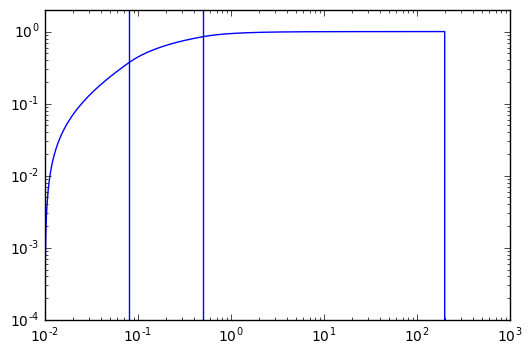

In [10]:
xmin = 0.01
xmax = 1000
xvalues = numpy.logspace(-3,3, 1e3)
x1 = 0.01
x2 = 0.08
x3 = 0.5
x4 = 200
a1 = -0.3
a2 = -1.3
a3 = -2.3
C1 = 0.1
yvalues =CDFbrokenPowerLaw(xvalues, x1, x2, x3, x4, a1, a2, a3, C1)

fig, axes = plt.subplots(1,1)
axes.plot(xvalues, yvalues)
axes.set_xscale('log')
axes.set_yscale('log')
axes.axvline(0.08)
axes.axvline(0.5)
axes.set_xlim(xmin, xmax)
axes.set_ylim(1e-4, 2)
plt.show()

So if we randomly draw a number between 0-1 (i.e. CDF(a)) we need to invert the CDF to know the value of a

If a < x2:
    
$$\left(\frac{ \left[ CDF(a) * (N_1 + N_2 + N_3) \right] + (\frac{1}{(\alpha_1 + 1)} C_1 x_1 ^{\alpha_1 + 1})}
       { \frac{1}{(\alpha_1 + 1)} C_1 }\right)^{\frac{1}{\alpha_1 + 1}} = a $$
             
If x2 < a < x3:

$$\left( \frac{ \left[ CDF(a) * (N_1 + N_2 + N_3)- (N_1) \right]  + (\frac{1}{(\alpha_2 + 1)} C_2 x_2 ^{\alpha_2 + 1})} {\frac{1}{(\alpha_2 + 1)} C_2 } \right)^{\frac{1}{\alpha2+1}} =a  $$

             
and finally if x3 < a < x4:

$$\left( \frac{ \left[ CDF(a) * (N_1 + N_2 + N_3)- (N_1+N_2) \right]  + (\frac{1}{(\alpha_3 + 1)} C_3 x_3 ^{\alpha_3 + 1})} { \frac{1}{(\alpha_3 + 1)} C_3 } \right)^{\frac{1}{\alpha3+1}} =a  $$



The problem is that we do not know in advance the value of a in order for us to pick the right equation
to solve for. 

However we do know the CDF(x2) and CDF(x3)

So if we draw y of  value between 0-1 then

$$0 \leq y \leq CDF(x2),\ \ then\ solve\ for\ a \leq x_2 $$
$$CDF(x2) \leq y \leq CDF(x3),\ \ then\ solve\ for\ x_2 \leq a \leq x_3 $$
$$CDF(x3) \leq y ,\ \ then\ solve\ for\ x_3 \leq a \leq x_4 $$

In [11]:
def invertCDFbrokenPowerLaw(CDF, x1, x2, x3, x4, a1, a2, a3, C1):
    #I specifically do floats against python rounding when dividing
    
    #The constants needed
    C2    = float(C1 * (x2**(a1-a2)))
    C3    = float(C2 * (x3**(a2-a3)))
    
    N1 = float(((1./(a1+1)) * C1 * (x2**(a1+1))) - ((1./(a1+1)) * C1 * (x1**(a1+1))))
    N2 = float(((1./(a2+1)) * C2 * (x3**(a2+1))) - ((1./(a2+1)) * C2 * (x2**(a2+1))))
    N3 = float(((1./(a3+1)) * C3 * (x4**(a3+1))) - ((1./(a3+1)) * C3 * (x3**(a3+1))))
    
    bottom = N1+N2+N3
    
    CDFx2 = CDFbrokenPowerLaw(numpy.array([x2,x2]), x1, x2, x3, x4, a1, a2, a3, C1)[0]
    CDFx3 = CDFbrokenPowerLaw(numpy.array([x3,x3]), x1, x2, x3, x4, a1, a2, a3, C1)[0]

    
    xvalues = numpy.zeros(len(CDF))
    
    mask1 = (CDF < CDFx2)
    xvalues[mask1] =  (((CDF[mask1]*(N1+N2+N3))  + \
                      ( (1./(a1+1))*C1*(x1**(a1+1))))/((1./(a1+1))*C1))**(1./(a1+1))
    
    mask2 = (CDFx2<= CDF) & (CDF < CDFx3)
    xvalues[mask2] = ((((CDF[mask2]*(N1+N2+N3))-(N1))  + \
                      ( (1./(a2+1))*C2*(x2**(a2+1))))/((1./(a2+1))*C2))**(1./(a2+1))
    
    mask3 = (CDFx3<= CDF) 
    xvalues[mask3] = ((((CDF[mask3]*(N1+N2+N3))-(N1+N2))  + \
                      ((1./(a3+1))*C3*(x3**(a3+1))))/((1./(a3+1))*C3))**(1./(a3+1))
    
    #Since we do not know the solution to a in advance we need to check which 
    #solutions from A1, A2, A3 to pick afterwards
    return xvalues


In [12]:
#testing
xmin = 0.01
xmax = 1000
xvalues = numpy.linspace(0.01, 200, 20)
x1 = 0.01
x2 = 0.08
x3 = 0.5
x4 = 200
a1 = -0.3
a2 = -1.3
a3 = -2.3
C1 = 1
CDF      = CDFbrokenPowerLaw(xvalues, x1, x2, x3, x4, a1, a2, a3, C1)

xvalues2 = invertCDFbrokenPowerLaw(CDF, x1, x2, x3, x4, a1, a2, a3, C1)

#going from x-> CDF and back introduces some difference 
#due to rounding errors, but it works up to at least 
#9 decimal places in this case
numpy.round(xvalues,9) == numpy.round(xvalues2,9)



array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True], dtype=bool)

0.0100000064794 199.926913752


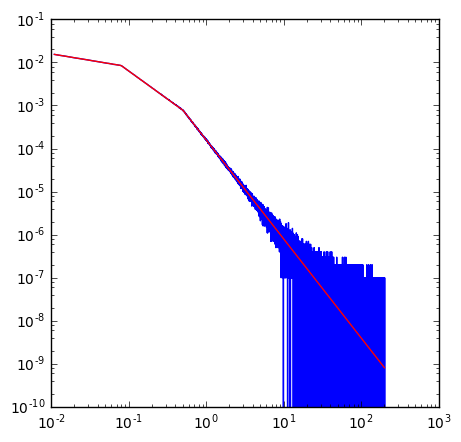

In [13]:


xmin = 0.01
xmax = 1000
x1 = 0.01
x2 = 0.08
x3 = 0.5
x4 = 200
a1 = -0.3
a2 = -1.3
a3 = -2.3
C1 = 1

CDFdraws   =  numpy.random.uniform(0,1,10*10**6)
xValues =  invertCDFbrokenPowerLaw(CDFdraws, x1, x2, x3, x4, a1, a2, a3, C1)

print min(xValues), max(xValues)
bins = numpy.linspace(x1, x4, 100000)
hist, bins = numpy.histogram(xValues, bins=bins)
hist = hist/(float(numpy.sum(hist)))

center = (bins[:-1] + bins[1:]) / 2
fig, axes = plt.subplots(1,1, figsize=(5,5))

xxx = center
yyy = threePartBrokenPowerLaw(xxx, x1, x2, x3, x4, a1, a2, a3, C1)
yyy = yyy/(float(numpy.sum(yyy)))


axes.plot(center, hist, label='normalised binned')
axes.plot(xxx, yyy, c='r', label='normalised analytic')
axes.set_xscale('log')
axes.set_yscale('log')
plt.show()

# 2 The loop for the sample universe

To have all the starformation we do not only want to draw primaries (m1)
from a broken powerlaw, we also want to have binaries (with binary fraction f)
of which the secondary (m2) follows a flat mass ration distribution

For all the distributions we use the inversion sampling, in other words
draw a value between 0-1 and project it to the corresponding x-value
using the inverse of the cumulative density function. The main benefit
is that we do not have to keep drawing values until we have the sample size
we want (as you do with accept reject), but instead draw once and use everything

The loop below is the code used in scripts folder for the cosmic integration



In [14]:
def createSampleUniverse():
    
    sampleSize     = 2*10**(6)
    binaryFraction = 0.7 

    #All the arrays we want to fill
    M1 = numpy.zeros(sampleSize)
    M2 = numpy.zeros(sampleSize)

    #Define the IMF broken powerlaw and calculate masses from inverted CDF
    x1 = 0.01
    x2 = 0.08
    x3 = 0.5
    x4 = 200
    a1 = -0.3
    a2 = -1.3
    a3 = -2.3
    C1 = 1
    
        #Given the defined three-part broken powerlaw,
    #We can sample a subset by using Mmin, Mmax.
    #We convert it to the respective values between
    #0-1 and only sample uniformly between those (woohoo :D)
    #Mmin and Mmax have to be between x1 and x4
    CDFmin = CDFbrokenPowerLaw(numpy.array([0.01]), x1, x2, x3, x4, a1, a2, a3, C1)
    CDFmax = CDFbrokenPowerLaw(numpy.array([150]), x1, x2, x3, x4, a1, a2, a3, C1)
    #All the random drawing that we need
    drawM1         = numpy.random.uniform(CDFmin,CDFmax,sampleSize)
    drawBinary     = numpy.random.uniform(0,1,sampleSize)
    drawM2         = numpy.random.uniform(0,1,sampleSize)

    
    M1 = invertCDFbrokenPowerLaw(drawM1, x1, x2, x3, x4, a1, a2, a3, C1)

    #Binary fraction is easier, since we draw between 0-1, every draw with 
    #value above binary fraction = single star and every value below is binary
    #for a single star we set M2=0 Msun.
    #Note that we assume that the binary Fraction is mass indepent
    #Future work to implenet Max Moe ps and qs options
    maskBinary = drawBinary < binaryFraction  #booleans

    #again for the secondary we assume the mass ratio distribution to be flat across
    #the whole parameter range so then the drawM2 (if it is in a binary) 
    #just becomes the mass fraction.

    M2[maskBinary] = numpy.multiply(drawM2[maskBinary],M1[maskBinary])
    #all the ones outside the mask remain zero
    return M1, M2

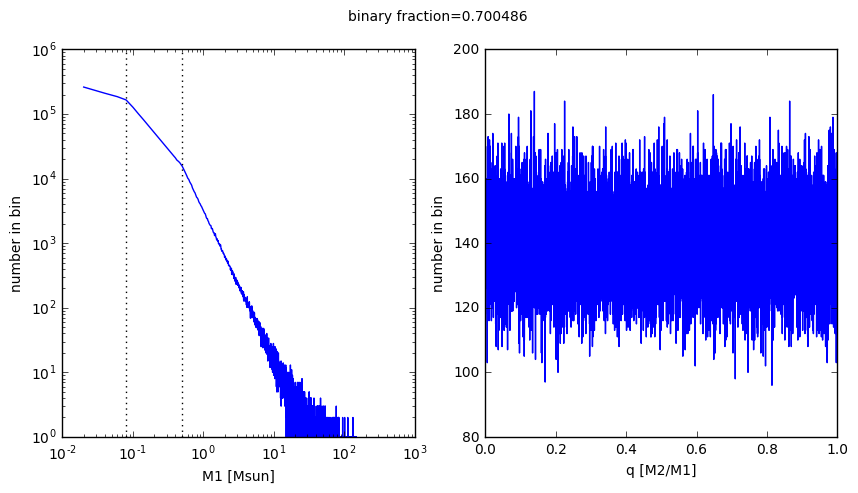

In [15]:
#Testing the function
M1, M2 = createSampleUniverse()
q = numpy.divide(M2, M1)

binaryMask     = (M2!=0)
binaryFraction = numpy.sum(binaryMask) / float(len(M1))

M1bins = numpy.linspace(0.01, 200, 10000)
qbins = numpy.linspace(0.0, 1, 10000)

histM1, M1bins = numpy.histogram(M1, bins=M1bins)
centerM1 = (M1bins[:-1] + M1bins[1:]) / 2.

histq, qbins = numpy.histogram(q[binaryMask], bins=qbins)
centerq = (qbins[:-1] + qbins[1:]) / 2

fig, axes = plt.subplots(1,2, figsize=(10,5))
axes[0].plot(centerM1, histM1, label='broken powerlaw sampled')
axes[0].set_xlabel('M1 [Msun]')
axes[0].set_ylabel('number in bin')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].axvline(0.08, c='k', linestyle=':')
axes[0].axvline(0.5, c='k', linestyle=':')

axes[1].plot(centerq, histq, label='mass ratio distribution sampled')
axes[1].set_xlabel('q [M2/M1]')
axes[1].set_ylabel('number in bin')

fig.suptitle('binary fraction=' + str(binaryFraction))
plt.show()

# 3- Determine the fraction evolved of all star formation by COMPAS

COMPAS evolves at every metallicity 100% binaries primaries with M1 between 
$$Mlower \leq M_1 \leq Mupper$$

To know the total amount of star formation we need to know the mass evolved by COMPAS

in each metallicity and the fractioc of the total star formation rate probed by COMPAS

### Get total masss evolved per metallicity using H5py (memory efficient)

In [16]:
def retrieveMassEvolvedPerZ():
    #Thanks Jim Barrett for this code snippet :+1:
    
    #After running this, I am not so happy anymore
    #This is too fast, no time to walk away and grab coffee ;p
    import h5py as h5
    path = '/home/cneijssel/Documents/Projects/Data/CosmicInt/COMPASOutput.h5'
    f = h5.File(path)
    allSystems = f['systems']
    metals = (allSystems['Metallicity1'])[...]
    m1s = (allSystems['mass1'])[...]
    m2s = (allSystems['mass2'])[...]
    total = []
    for Z in numpy.unique(metals):
        mask = metals == Z
        total.append(numpy.sum(m1s[mask]) + numpy.sum(m2s[mask]))
    return numpy.array(total)
totalMassEvolvedPerZ = retrieveMassEvolvedPerZ()
print totalMassEvolvedPerZ

[ 65212935.16482399  65261909.36139897  65218435.25367005
  65204492.55431402  65313564.576672    65284952.55375397
  65144782.21590902  65226769.97921298  65295027.671524    65161561.65472502
  65287611.17660601  65148236.03991402  65223347.17382995
  65220288.00112899  65161365.76594803  65163523.89049605
  65194673.14910597  65168515.67513196  65238904.48502401
  65298821.64467798  65158398.41574603  65262393.70105599  65283202.828154
  65229317.66974601  65154190.865692    65209832.79725101
  65216190.18410695  65204955.25797401  65184342.19017799
  65112198.02970402]


###  Fraction evolved by COMPAS

The fraction evolved by COMPAS depends on the setup of the simulation (lookup the pythonSubmit.py)

For the Cosmic Integration paper the folling was done:
    
Primaries with masses between 5 and 150 Msun all in binaries.





In [19]:
Mlower = 5.
Mupper = 150.
M1, M2 = createSampleUniverse()

totalMassInStarFormation = numpy.sum(M1) + numpy.sum(M2)

#Now mask M1 and M2 to see what lies in the range of COMPAS
maskM1 = (M1>=Mlower) & (M1<=Mupper)
maskBinaries = (M2!=0)
mask = maskM1 & maskBinaries
print numpy.sum(mask) / float(len(M1))
print numpy.sum(M1) 
print numpy.sum(M2)
totalMassEvolvedCOMPAS = numpy.sum(M1[mask]) + numpy.sum(M2[mask])
print numpy.sum(totalMassInStarFormation)
print  numpy.sum(totalMassEvolvedCOMPAS)
#multiplication fraction
fraction = totalMassEvolvedCOMPAS/float(totalMassInStarFormation)

#so we need to muliplu the mass evolved per metallicity times (1/fraction)
#to know the total mass evolved per metallicity
print (1/fraction)

#MassEvolvedPerZ = retrieveMassEvolvedPerZ()

#totalMassEvolvedPerZ = (MassEvolvedPerZ)/(fraction)

print totalMassEvolvedPerZ

0.005239
768011.009353
268011.065269
1036022.07462
219170.033596
4.72702429992
[  3.09148081e+08   3.09380247e+08   3.09174154e+08   3.09108058e+08
   3.09625124e+08   3.09489486e+08   3.08824995e+08   3.09213666e+08
   3.09537248e+08   3.08904540e+08   3.09502089e+08   3.08841368e+08
   3.09197440e+08   3.09182937e+08   3.08903611e+08   3.08913842e+08
   3.09061508e+08   3.08937506e+08   3.09271191e+08   3.09555234e+08
   3.08889544e+08   3.09382543e+08   3.09481191e+08   3.09225743e+08
   3.08869598e+08   3.09133374e+08   3.09163511e+08   3.09110251e+08
   3.09012533e+08   3.08670527e+08]
